# **作业说明：**

**✓代码跑通**

请大家根据课上所学内容，在 VGGNet类中补全代码，构造VGG网络，保证程序跑通。在VGG构造成功的基础上，可尝试构造其他网络。

**✓调优**

思考并动手进行调优，以在验证集上的准确率为评价指标，验证集上准确率越高，得分越高！

# **任务描述：**


如何根据据图像的视觉内容为图像赋予一个语义类别（例如，教室、街道等）是图像场景分类的目标，也是图像检索、图像内容分析和目标识别等问题的基础。但由于图片的尺度、角度、光照等多样性以及场景定义的复杂性，场景分类一直是计算机视觉中的一个挑战性问题。

<br/>

**本实践旨在通过一个场景分类的案列，让大家理解和掌握如何使用飞桨动态图搭建一个经典的卷积神经网络。**

<br/>

**特别提示：本实践所用数据集均来自互联网，请勿用于商务用途。**

In [38]:
import os
import zipfile
import random
import json
import paddle
import sys
import numpy as np
from PIL import Image
from PIL import ImageEnhance
import paddle.fluid as fluid
import matplotlib.pyplot as plt


'''
参数配置
'''
train_parameters = {
    "input_size": [3, 224, 224],                              #输入图片的shape
    "class_dim": -1,                                          #分类数
    "src_path":"/home/aistudio/data/data38478/scenes.zip",    #原始数据集路径
    "target_path":"/home/aistudio/data/",                     #要解压的路径
    "train_list_path": "/home/aistudio/data/train.txt",       #train.txt路径
    "eval_list_path": "/home/aistudio/data/eval.txt",         #eval.txt路径
    "readme_path": "/home/aistudio/data/readme.json",         #readme.json路径
    "label_dict":{},                                          #标签字典
    "num_epochs": 1,                                         #训练轮数
    "train_batch_size": 64,                                   #训练时每个批次的大小
    "learning_strategy": {                                    #优化函数相关的配置
        "lr": 0.001                                          #超参数学习率
    } 
}

In [39]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3, 224, 224],                                #输入图片的shape
    "class_dim": -1,                                          #分类数
    "src_path":"/home/aistudio/data/data38478/scenes.zip",                    #原始数据集路径
    "target_path":"/home/aistudio/data/",                     #要解压的路径
    "train_list_path": "/home/aistudio/data/train.txt",       #train.txt路径
    "eval_list_path": "/home/aistudio/data/eval.txt",         #eval.txt路径
    "readme_path": "/home/aistudio/data/readme.json",         #readme.json路径
    "label_dict":{},                                          #标签字典
    "num_epochs": 1,                                         #训练轮数
    "train_batch_size": 64,                                   #训练时每个批次的大小
    "learning_strategy": {                                    #优化函数相关的配置
        # "lr": 0.0001                                          #超参数学习率
    } ,
    "dropout_prob": 0.2,
    "dropout_seed": None,
    "save_freeze_dir": "./freeze-model",
    "save_persistable_dir": "./persistable-params",
    "continue_train": True,        # 是否接着上一次保存的参数接着训练，优先级高于预训练模型    
    "pretrained": False,            # 是否使用预训练的模型    
    "mode": "train",
    "mean_rgb": [127.5, 127.5, 127.5],  # 常用图片的三通道均值，通常来说需要先对训练数据做统计，此处仅取中间值    
    "use_gpu": True,
    "early_stop": {
        "sample_frequency": 50,
        "successive_limit": 5,
        "good_acc1": 0.92
    },
    "rsm_strategy": {
        "learning_rate": 0.001,
        "lr_epochs": [20, 40, 60, 80, 100],
        "lr_decay": [1, 0.5, 0.25, 0.1, 0.05, 0.01]
    },
    "image_enhance_strategy": {  # 图像增强相关策略  
        "need_distort": True,  # 是否启用图像颜色增强  
        "need_rotate": True,   # 是否需要增加随机角度  
        "need_crop": True,      # 是否要增加裁剪  
        "need_flip": True,      # 是否要增加水平随机翻转  
        "hue_prob": 0.5,  
        "hue_delta": 18,  
        "contrast_prob": 0.5,  
        "contrast_delta": 0.5,  
        "saturation_prob": 0.5,  
        "saturation_delta": 0.5,  
        "brightness_prob": 0.5,  
        "brightness_delta": 0.125  
    }, 
}

# **一、数据准备**

（1）解压原始数据集

（2）按照比例划分训练集与验证集

（3）乱序，生成数据列表

（4）构造训练数据集提供器和验证数据集提供器

In [40]:

def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至target_path目录下
    '''
    if(not os.path.isdir(target_path + "scenes")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()

In [41]:

def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path+"scenes/"
    class_dirs = os.listdir(data_list_path)  
    #总的图像数量
    all_class_images = 0
    #存放类别标签
    class_label=0
    #存放类别数目
    class_dim = 0
    #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别，['river', 'lawn','church','ice','desert']
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = data_list_path  + class_dir
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                name_path = path + '/' + img_path                       # 每张图片的路径
                if class_sum % 8 == 0:                                  # 每8张图片取一个做验证数据
                    eval_sum += 1                                       # test_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1                                          #每类图片的数目
                all_class_images += 1                                   #所有类图片的数目
             
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1 
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim
  
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
            
    random.shuffle(trainer_list)
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')


def custom_reader(file_list):
    '''
    自定义reader
    '''
    def reader():
        with open(file_list, 'r') as f:
            lines = [line.strip() for line in f]
            for line in lines:
                img_path, lab = line.strip().split('\t')
                img = Image.open(img_path) 
                if img.mode != 'RGB': 
                    img = img.convert('RGB') 
                img = img.resize((224, 224), Image.BILINEAR)
                img = np.array(img).astype('float32') 
                img = img.transpose((2, 0, 1))  # HWC to CHW 
                img = img/255                   # 像素值归一化 
                yield img, int(lab) 
    return reader


In [42]:
import os
import math
import codecs
import numpy as np
from PIL import Image, ImageEnhance

def resize_img(img, target_size):
    """
    强制缩放图片
    :param img:
    :param target_size:
    :return:
    """
    img = img.resize((target_size[1], target_size[2]), Image.BILINEAR)
    return img


def random_crop(img, scale=[0.08, 1.0], ratio=[3. / 4., 4. / 3.]):
    aspect_ratio = math.sqrt(np.random.uniform(*ratio))
    w = 1. * aspect_ratio
    h = 1. / aspect_ratio

    bound = min((float(img.size[0]) / img.size[1]) / (w**2),
                (float(img.size[1]) / img.size[0]) / (h**2))
    scale_max = min(scale[1], bound)
    scale_min = min(scale[0], bound)

    target_area = img.size[0] * img.size[1] * np.random.uniform(scale_min,
                                                                scale_max)
    target_size = math.sqrt(target_area)
    w = int(target_size * w)
    h = int(target_size * h)

    i = np.random.randint(0, img.size[0] - w + 1)
    j = np.random.randint(0, img.size[1] - h + 1)

    img = img.crop((i, j, i + w, j + h))
    img = img.resize((train_parameters['input_size'][1], train_parameters['input_size'][2]), Image.BILINEAR)
    return img


def rotate_image(img):
    """
    图像增强，增加随机旋转角度
    """
    angle = np.random.randint(-14, 15)
    img = img.rotate(angle)
    return img


def random_brightness(img):
    """
    图像增强，亮度调整
    :param img:
    :return:
    """
    prob = np.random.uniform(0, 1)
    if prob < train_parameters['image_enhance_strategy']['brightness_prob']:
        brightness_delta = train_parameters['image_enhance_strategy']['brightness_delta']
        delta = np.random.uniform(-brightness_delta, brightness_delta) + 1
        img = ImageEnhance.Brightness(img).enhance(delta)
    return img


def random_contrast(img):
    """
    图像增强，对比度调整
    :param img:
    :return:
    """
    prob = np.random.uniform(0, 1)
    if prob < train_parameters['image_enhance_strategy']['contrast_prob']:
        contrast_delta = train_parameters['image_enhance_strategy']['contrast_delta']
        delta = np.random.uniform(-contrast_delta, contrast_delta) + 1
        img = ImageEnhance.Contrast(img).enhance(delta)
    return img


def random_saturation(img):
    """
    图像增强，饱和度调整
    :param img:
    :return:
    """
    prob = np.random.uniform(0, 1)
    if prob < train_parameters['image_enhance_strategy']['saturation_prob']:
        saturation_delta = train_parameters['image_enhance_strategy']['saturation_delta']
        delta = np.random.uniform(-saturation_delta, saturation_delta) + 1
        img = ImageEnhance.Color(img).enhance(delta)
    return img


def random_hue(img):
    """
    图像增强，色度调整
    :param img:
    :return:
    """
    prob = np.random.uniform(0, 1)
    if prob < train_parameters['image_enhance_strategy']['hue_prob']:
        hue_delta = train_parameters['image_enhance_strategy']['hue_delta']
        delta = np.random.uniform(-hue_delta, hue_delta)
        img_hsv = np.array(img.convert('HSV'))
        img_hsv[:, :, 0] = img_hsv[:, :, 0] + delta
        img = Image.fromarray(img_hsv, mode='HSV').convert('RGB')
    return img


def distort_color(img):
    """
    概率的图像增强
    :param img:
    :return:
    """
    prob = np.random.uniform(0, 1)
    # Apply different distort order
    if prob < 0.35:
        img = random_brightness(img)
        img = random_contrast(img)
        img = random_saturation(img)
        img = random_hue(img)
    elif prob < 0.7:
        img = random_brightness(img)
        img = random_saturation(img)
        img = random_hue(img)
        img = random_contrast(img)
    return img


def custom_image_reader(file_list, mode):
    """
    自定义用户图片读取器，先初始化图片种类，数量
    :param file_list:
    :param data_dir:
    :param mode:
    :return:
    """


    def reader():
        # np.random.shuffle(lines)
        with open(file_list, 'r') as f:
            lines = [line.strip() for line in f]
            for line in lines:
                if mode == 'train':
                    img_path, label = line.strip().split('\t')
                    img = Image.open(img_path)
                    try:
                        if img.mode != 'RGB':
                            img = img.convert('RGB')
                        if train_parameters['image_enhance_strategy']['need_distort']:
                            img = distort_color(img)
                        if train_parameters['image_enhance_strategy']['need_rotate']:
                            img = rotate_image(img)
                        if train_parameters['image_enhance_strategy']['need_crop']:
                            img = random_crop(img, train_parameters['input_size'])
                        if train_parameters['image_enhance_strategy']['need_flip']:
                            mirror = int(np.random.uniform(0, 2))
                            if mirror == 1:
                                img = img.transpose(Image.FLIP_LEFT_RIGHT)
                        img = resize_img(img, train_parameters['input_size'])
                        # HWC--->CHW && normalized
                        img = np.array(img).astype('float32')
                        img -= train_parameters['mean_rgb']
                        img = img.transpose((2, 0, 1))  # HWC to CHW
                        img *= 0.007843                 # 像素值归一化
                        yield img, int(label)
                    except Exception as e:
                        pass                            # 以防某些图片读取处理出错，加异常处理
                if mode == 'val':
                    img_path, label = line.strip().split('\t')
                    img = Image.open(img_path)
                    img = Image.open(img_path)
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                    img = resize_img(img, train_parameters['input_size'])
                    # HWC--->CHW && normalized
                    img = np.array(img).astype('float32')
                    img -= train_parameters['mean_rgb']
                    img = img.transpose((2, 0, 1))  # HWC to CHW
                    img *= 0.007843  # 像素值归一化
                    yield img, int(label)
                elif mode == 'test':
                    img_path = line
                    img = Image.open(img_path)
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                    img = resize_img(img, train_parameters['input_size'])
                    # HWC--->CHW && normalized
                    img = np.array(img).astype('float32')
                    img -= train_parameters['mean_rgb']
                    img = img.transpose((2, 0, 1))  # HWC to CHW
                    img *= 0.007843  # 像素值归一化
                    yield img

    return reader

In [43]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
batch_size=train_parameters['train_batch_size']

'''
解压原始数据到指定路径
'''
unzip_data(src_path,target_path)

'''
划分训练集与验证集，乱序，生成数据列表
'''
#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
    
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

'''
构造数据提供器
'''

train_reader = paddle.batch(custom_image_reader(train_list_path,'train'),
                            batch_size=batch_size,
                            drop_last=True)
eval_reader = paddle.batch(custom_image_reader(eval_list_path,'val'),
                            batch_size=batch_size,
                            drop_last=True)
# train_reader = paddle.batch(custom_reader(train_list_path),
#                             batch_size=batch_size,
#                             drop_last=True)
# eval_reader = paddle.batch(custom_reader(eval_list_path),
#                             batch_size=batch_size,
#                             drop_last=True)


生成数据列表完成！


# **二、模型配置**

![](https://ai-studio-static-online.cdn.bcebos.com/9ca0744272b0449186f766afcabadd598e24679088a4438dafede05a71b7c141)

VGG的核心是五组卷积操作，每两组之间做Max-Pooling空间降维。同一组内采用多次连续的3X3卷积，卷积核的数目由较浅组的64增多到最深组的512，同一组内的卷积核数目是一样的。卷积之后接两层全连 接层，之后是分类层。由于每组内卷积层的不同，有11、13、16、19层这几种模型，上图展示一个16层的网络结构。



In [44]:

class ConvPool(fluid.dygraph.Layer):
    '''卷积+池化'''
    def __init__(self,
                 num_channels,
                 num_filters,
                 filter_size,
                 pool_size,
                 pool_stride,
                 groups,
                 conv_stride=1,
                 conv_padding=1,
                 act=None,
                 pool_type='max'
                 ):
        super(ConvPool, self).__init__()  

        self._conv2d_list = []

        for i in range(groups):
            conv2d = self.add_sublayer(   #返回一个由所有子层组成的列表。
                'bb_%d' % i,
                fluid.dygraph.Conv2D(
                num_channels=num_channels, #通道数
                num_filters=num_filters,   #卷积核个数
                filter_size=filter_size,   #卷积核大小
                stride=conv_stride,        #步长
                padding=conv_padding,      #padding大小，默认为0
                act=act)
            )
            num_channels = num_filters
            self._conv2d_list.append(conv2d)   

        self._pool2d = fluid.dygraph.Pool2D(
            pool_size=pool_size,           #池化核大小
            pool_type=pool_type,           #池化类型，默认是最大池化
            pool_stride=pool_stride        #池化步长
            )

    def forward(self, inputs):
        x = inputs
        for conv in self._conv2d_list:
            x = conv(x)
        x = self._pool2d(x)
        return x

### ###在以下cell中完成VGG网络的定义###

In [45]:
class VGGNet(fluid.dygraph.Layer):
    '''
    VGG网络
    '''
    def __init__(self):
        super(VGGNet, self).__init__()       
        


    def forward(self, inputs, label=None):
        """前向计算"""



        
        if label is not None:
            acc = fluid.layers.accuracy(input=out, label=label)
            return out, acc
        else:
            return out

In [46]:
import paddle
import paddle.fluid as fluid
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, BatchNorm, Linear


class BNConvLayer(fluid.dygraph.Layer):
    def __init__(self,
                 name_scope,
                 num_filters,
                 num_channels,
                 filter_size,
                 stride=1,
                 groups=1,
                 act='relu'):
        super(BNConvLayer, self).__init__(name_scope)

        self._conv = Conv2D(
            num_channels=num_channels,
            num_filters=num_filters,
            filter_size=filter_size,
            stride=stride,
            padding=(filter_size - 1) // 2,
            groups=groups,
            act=None,
            bias_attr=False)

        self._batch_norm = BatchNorm(num_channels, act=act)

    def forward(self, inputs):
        y = self._batch_norm(inputs)
        y = self._conv(y)

        return y


class BottleneckLayer(fluid.dygraph.Layer):
    def __init__(self,
                 name_scope,
                 num_filters,
                 num_channels,
                 drop_out_prob):
        super(BottleneckLayer, self).__init__(name_scope)

        self.bn_conv1 = BNConvLayer(
            self.full_name(),
            num_filters=num_filters * 4,
            num_channels=num_channels,
            filter_size=1)
        self.bn_conv2 = BNConvLayer(
            self.full_name(),
            num_filters=num_filters,
            num_channels=num_filters * 4,
            filter_size=3)
        self.drop_out_prob = drop_out_prob

    def forward(self, inputs):
        y = self.bn_conv1(inputs)
        y = fluid.layers.dropout(x=y, dropout_prob=self.drop_out_prob)
        y = self.bn_conv2(y)
        y = fluid.layers.dropout(x=y, dropout_prob=self.drop_out_prob)
        return y


class DenseBlock(fluid.dygraph.Layer):
    def __init__(self,
                 name_scope,
                 num_filters,
                 num_channels,
                 block_num,
                 drop_out_prob):
        super(DenseBlock, self).__init__(name_scope)

        self.block = BottleneckLayer(
            self.full_name(),
            num_filters=num_filters,
            num_channels=num_channels,
            drop_out_prob=drop_out_prob)

        self.block_num = block_num
        channels = num_channels + num_filters
        self.convs = []
        for i in range(self.block_num - 1):
            conv_block = self.add_sublayer(
                'bb_%d_%d' % (i, i),
                BottleneckLayer(
                    self.full_name(),
                    num_filters=num_filters,
                    num_channels=channels,
                    drop_out_prob=drop_out_prob))
            self.convs.append(conv_block)
            channels = channels + num_filters

        self.out_channel = channels

    def forward(self, inputs):

        layers = []
        layers.append(inputs)
        y = self.block(inputs)
        layers.append(y)
        for conv in self.convs:
            y = paddle.fluid.layers.concat(layers, axis=1)
            y = conv(y)
            layers.append(y)
        y = paddle.fluid.layers.concat(layers, axis=1)
        return y


class TransitionLayer(fluid.dygraph.Layer):
    def __init__(self,
                 name_scope,
                 num_filters,
                 num_channels,
                 drop_out_prob):
        super(TransitionLayer, self).__init__(name_scope)

        self.conv = BNConvLayer(
            self.full_name(),
            num_filters=num_filters,
            num_channels=num_channels,
            filter_size=1)

        self.pool2d = Pool2D(
            pool_size=2,
            pool_stride=2,
            pool_type='avg')

        self.dropout_prob = drop_out_prob

    def forward(self, inputs):
        y = self.conv(inputs)
        y = fluid.layers.dropout(x=y, dropout_prob=self.dropout_prob)
        y = self.pool2d(y)

        return y


class LoopLayer(fluid.dygraph.Layer):
    def __init__(self,
                 name_scope,
                 num_filters,
                 num_channels,
                 block_num,
                 drop_out_prob):
        super(LoopLayer, self).__init__(name_scope)

        self.denseblock = DenseBlock(
            self.full_name(),
            num_filters=num_filters,
            num_channels=num_channels,
            block_num=block_num,
            drop_out_prob=drop_out_prob)

        self.channel = self.denseblock.out_channel

        self.transblock = TransitionLayer(
            self.full_name(),
            num_filters=num_filters,
            num_channels=self.channel,
            drop_out_prob=drop_out_prob)

    def forward(self, inputs):
        y = self.denseblock(inputs)
        y = self.transblock(y)
        return y


class DenseNet(fluid.dygraph.Layer):
    def __init__(self, name_scope, layers, dropout_prob, class_dim=5):
        super(DenseNet, self).__init__(name_scope)

        self.layers = layers
        self.dropout_prob = dropout_prob

        layer_count_dict = {
            121: (32, [6, 12, 24, 16]),
            169: (32, [6, 12, 32, 32]),
            201: (32, [6, 12, 48, 32]),
            161: (48, [6, 12, 36, 24])
        }
        layer_conf = layer_count_dict[self.layers]

        self.conv1 = Conv2D(
            num_channels=3,
            num_filters=layer_conf[0] * 2,
            filter_size=7,
            stride=2,
            padding=3,
            groups=1,
            act=None,
            bias_attr=False)

        self.pool1 = Pool2D(
            pool_size=3,
            pool_padding=1,
            pool_stride=2,
            pool_type='max')
        channels = layer_conf[0] * 2

        self.convs = []
        for i in range(len(layer_conf[1]) - 1):
            conv_block = self.add_sublayer(
                'bb_%d_%d' % (i, i),
                LoopLayer(
                    self.full_name(),
                    num_filters=layer_conf[0],
                    num_channels=channels,
                    block_num=layer_conf[1][i],
                    drop_out_prob=self.dropout_prob))
            channels = layer_conf[0]
            self.convs.append(conv_block)

        self.conv3 = DenseBlock(
            self.full_name(),
            num_filters=layer_conf[1][-1],
            num_channels=layer_conf[0],
            block_num=layer_conf[0],
            drop_out_prob=self.dropout_prob)

        self.pool2 = Pool2D(
            global_pooling=True,
            pool_type='avg')

        self.fc = Linear(input_dim=544,
                         output_dim=class_dim,
                         act='softmax')

    def forward(self, inputs, label=None):
        y = self.conv1(inputs)
        y = self.pool1(y)
        #   print(len(self.convs))
        for conv in self.convs:
            y = conv(y)
        y = self.conv3(y)
        y = self.pool2(y)
        y = fluid.layers.reshape(y, [-1, 544])
        y = self.fc(y)
        if label is not None:
            acc = fluid.layers.accuracy(input=y, label=label)
            return y, acc
        else:
            return y

# **三、模型训练 && 四、模型评估**

In [47]:
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("loss/acc", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()


def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

In [48]:
def optimizer_rms_setting(parameters):
    """  
    阶梯型的学习率适合比较大规模的训练数据  
    """
    batch_size = train_parameters["train_batch_size"]
    iters = 4375#train_parameters["image_count"] // batch_size
    learning_strategy = train_parameters['rsm_strategy']
    lr = learning_strategy['learning_rate']

    boundaries = [i * iters for i in learning_strategy["lr_epochs"]]
    values = [i * lr for i in learning_strategy["lr_decay"]]

    optimizer = fluid.optimizer.RMSProp(
        learning_rate=fluid.layers.piecewise_decay(boundaries, values),
        parameter_list=parameters)

    return optimizer

In [49]:
def eval_net(reader, model):
    acc_set = []

    for batch_id, data in enumerate(reader()):
        dy_x_data = np.array([x[0] for x in data]).astype('float32')
        y_data = np.array([x[1] for x in data]).astype('int')
        y_data = y_data[:, np.newaxis]
        img = fluid.dygraph.to_variable(dy_x_data)
        label = fluid.dygraph.to_variable(y_data)
        label.stop_gradient = True
        prediction, acc = model(img, label)

        acc_set.append(float(acc.numpy()))

        # get test acc and loss
    acc_val_mean = np.array(acc_set).mean()

    return acc_val_mean

5
{'0': 'church', '1': 'desert', '2': 'ice', '3': 'river', '4': 'lawn'}
Loss at epoch 0 step 0: [1.8148091], acc: [0.171875]
Loss at epoch 0 step 1: [7.181167], acc: [0.140625]
Loss at epoch 0 step 2: [2.901331], acc: [0.3125]
Loss at epoch 0 step 3: [2.1451533], acc: [0.1875]
Loss at epoch 0 step 4: [1.5507878], acc: [0.203125]
Loss at epoch 0 step 5: [2.768488], acc: [0.265625]
Loss at epoch 0 step 6: [1.496211], acc: [0.296875]
Loss at epoch 0 step 7: [1.693261], acc: [0.234375]
Loss at epoch 0 step 8: [1.6101263], acc: [0.265625]
Loss at epoch 0 step 9: [1.5058819], acc: [0.421875]
Loss at epoch 0 step 10: [1.5341115], acc: [0.328125]
Loss at epoch 0 step 11: [1.7926316], acc: [0.203125]
Loss at epoch 0 step 12: [1.9910158], acc: [0.265625]
Loss at epoch 0 step 13: [1.4658195], acc: [0.375]
Loss at epoch 0 step 14: [1.5076351], acc: [0.40625]
Loss at epoch 0 step 15: [1.4395751], acc: [0.34375]
Loss at epoch 0 step 16: [1.5106814], acc: [0.359375]
Loss at epoch 0 step 17: [2.164578

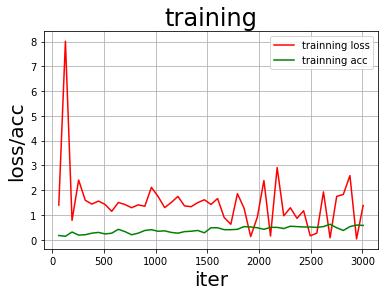

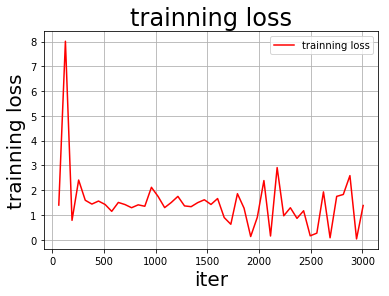

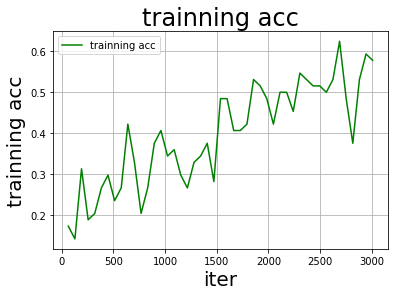

In [50]:
'''
模型训练
'''
with fluid.dygraph.guard(place = fluid.CUDAPlace(0)):
#with fluid.dygraph.guard():
    print(train_parameters['class_dim'])
    print(train_parameters['label_dict'])
    # vgg = VGGNet()
    # optimizer=fluid.optimizer.AdamOptimizer(learning_rate=train_parameters['learning_strategy']['lr'],parameter_list=vgg.parameters()) 
    net = DenseNet("densenet", layers=121, dropout_prob=train_parameters['dropout_prob'],
                    class_dim=train_parameters['class_dim'])
    optimizer = optimizer_rms_setting(net.parameters())
    # if train_parameters["continue_train"]:
    #     model, _ = fluid.dygraph.load_dygraph(train_parameters["save_persistable_dir"])
    #     net.load_dict(model)
    best_acc = 0
    for epoch_num in range(train_parameters['num_epochs']):
        for batch_id, data in enumerate(train_reader()):
            dy_x_data = np.array([x[0] for x in data]).astype('float32').reshape(-1, 3, train_parameters['input_size'][1], train_parameters['input_size'][2])           
            y_data = np.array([x[1] for x in data]).astype('int64')      
            y_data = y_data[:, np.newaxis]

            #将Numpy转换为DyGraph接收的输入
            img = fluid.dygraph.to_variable(dy_x_data)
            label = fluid.dygraph.to_variable(y_data)

            # out,acc = vgg(img,label)
            out,acc = net(img, label)
            loss = fluid.layers.cross_entropy(out, label)
            avg_loss = fluid.layers.mean(loss)

            #使用backward()方法可以执行反向网络
            avg_loss.backward()
            optimizer.minimize(avg_loss)
             
            #将参数梯度清零以保证下一轮训练的正确性
            # vgg.clear_gradients()
            net.clear_gradients()
            

            all_train_iter=all_train_iter+train_parameters['train_batch_size']
            all_train_iters.append(all_train_iter)
            all_train_costs.append(loss.numpy()[0])
            all_train_accs.append(acc.numpy()[0])
                
            if batch_id % 1 == 0:
                print("Loss at epoch {} step {}: {}, acc: {}".format(epoch_num, batch_id, avg_loss.numpy(), acc.numpy()))
        net.eval()
        epoch_acc = eval_net(eval_reader, net)
        net.train()
        if epoch_acc > best_acc:
            fluid.dygraph.save_dygraph(net.state_dict(), train_parameters["save_persistable_dir"])
            fluid.dygraph.save_dygraph(optimizer.state_dict(), train_parameters["save_persistable_dir"])
            best_acc = epoch_acc
    draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning loss","trainning acc")  
    draw_process("trainning loss","red",all_train_iters,all_train_costs,"trainning loss")
    draw_process("trainning acc","green",all_train_iters,all_train_accs,"trainning acc")  
    
    #保存模型参数
    # fluid.save_dygraph(vgg.state_dict(), "vgg")   
    # print("Final loss: {}".format(avg_loss.numpy()))


In [51]:
'''
模型校验
'''
with fluid.dygraph.guard():
    # model, _ = fluid.load_dygraph("vgg")
    model, _ = fluid.load_dygraph(train_parameters["save_persistable_dir"])
    # vgg = VGGNet()
    net = DenseNet("densenet", layers = 121, dropout_prob = train_parameters['dropout_prob'], class_dim = train_parameters['class_dim'])
    # vgg.load_dict(model)
    net.load_dict(model)
    # vgg.eval()
    net.eval()
    accs = []
    for batch_id, data in enumerate(eval_reader()):
        dy_x_data = np.array([x[0] for x in data]).astype('float32').reshape(-1, 3,train_parameters['input_size'][1], train_parameters['input_size'][2])
        y_data = np.array([x[1] for x in data]).astype('int')
        y_data = y_data[:, np.newaxis]
        
        img = fluid.dygraph.to_variable(dy_x_data)
        label = fluid.dygraph.to_variable(y_data)

        # out, acc = vgg(img, label)
        out, acc = net(img, label)
        lab = np.argsort(out.numpy())
        accs.append(acc.numpy()[0])
print(np.mean(accs))

0.6223958


# **五、模型预测**

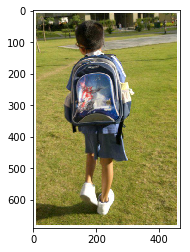

第1个样本,被预测为：desert
结束


In [53]:
import os
import zipfile

def unzip_infer_data(src_path,target_path):
    '''
    解压预测数据集
    '''
    if(not os.path.isdir(target_path + "scene_infer")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()


def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((224, 224), Image.BILINEAR)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1))  # HWC to CHW 
    img = img/255                # 像素值归一化 
    return img


infer_src_path = '/home/aistudio/data/data38479/scene_infer.zip'
infer_dst_path = '/home/aistudio/data/'
unzip_infer_data(infer_src_path,infer_dst_path)

label_dic = train_parameters['label_dict']

'''
模型预测
'''
with fluid.dygraph.guard():
    # model, _ = fluid.dygraph.load_dygraph("vgg")
    # vgg = VGGNet()
    # vgg.load_dict(model)
    # vgg.eval()
    model, _ = fluid.load_dygraph(train_parameters["save_persistable_dir"])
    net = DenseNet("densenet", layers = 121, dropout_prob = train_parameters['dropout_prob'], class_dim = train_parameters['class_dim'])
    net.load_dict(model)
    net.eval()
    #展示预测图片
    infer_path='data/scene_infer/lawn01.jpg'
    img = Image.open(infer_path)
    plt.imshow(img)          #根据数组绘制图像
    plt.show()               #显示图像

    #对预测图片进行预处理
    infer_imgs = []
    infer_imgs.append(load_image(infer_path))
    infer_imgs = np.array(infer_imgs)
   
    for  i in range(len(infer_imgs)):
        data = infer_imgs[i]
        dy_x_data = np.array(data).astype('float32')
        dy_x_data=dy_x_data[np.newaxis,:, : ,:]
        img = fluid.dygraph.to_variable(dy_x_data)
        # out = vgg(img)
        out = net(img)
        lab = np.argmax(out.numpy())  #argmax():返回最大数的索引
        print("第{}个样本,被预测为：{}".format(i+1,label_dic[str(lab)]))
        
print("结束")
